## 0. Libraries and Personal Tools

In [1]:
import sys
from os.path import abspath

from multiprocessing import cpu_count

from gc import collect

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the default figure size and theme to display good looking matplotlib plots.
rcParams["figure.figsize"] = (10, 6)
plt.style.use("fivethirtyeight")

In [3]:
# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

from src.models.train_model import BaseModel

## 1. Build Base Model

In [4]:
base_model = BaseModel()
base_model.read_config("../models/config.yaml")
features, target = base_model.get_data()
base_model.build_base_pipeline()

In [5]:
from pandas.core.frame import DataFrame
DataFrame(base_model.base_pipeline.fit_transform(base_model.data.sample(frac=0.1, random_state=777))).isna().sum().sum()

0

## 2. Parameter Optimization

### 2.1. Split Data

In [6]:
from src.utils import create_kf_groups

from scipy import stats
from numpy import linspace

from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, GroupKFold
from xgboost import XGBClassifier

In [7]:
from sklearn.model_selection import GroupShuffleSplit

gsp = GroupShuffleSplit(n_splits=2, test_size=0.90, random_state=777)
train_index, test_index = next(gsp.split(base_model.data, groups=base_model.data.index.get_level_values("game_num")))

X_train = base_model.data[features].iloc[train_index]
y_train = base_model.data[target].iloc[train_index]

X_test = base_model.data[features].iloc[test_index]
y_test = base_model.data[target].iloc[test_index]

### 2.2. Define Parameter Grid

In [8]:
if base_model.config["model"]["ipca"]["batch_size"] == "auto":
    TOTAL_IPCA_BATCHES = 50
    ipca_batch = int(round(len(X_train) / TOTAL_IPCA_BATCHES, -3))
else:
    ipca_batch = base_model.config["model"]["ipca"]["batch_size"]
ipca_batch

4000

In [9]:
base_model.base_pipeline.steps.append((
    "ipca", 
    IncrementalPCA(
        n_components=base_model.config["model"]["ipca"]["n_components"], 
        batch_size=ipca_batch,
        whiten=base_model.config["model"]["ipca"]["whiten"]
        ),
    ))


In [10]:
xgb_param_dists = [
    {
        "xgb__objective": ['binary:logistic'],
        "xgb__n_estimators": linspace(50, 500, 10).astype(int), 
        "xgb__learning_rate": stats.uniform(0.01, 0.05),
        "xgb__max_depth": linspace(3, 10, 7).astype(int),
        "xgb__gamma": stats.uniform(0, 2),
        "xgb__subsample": stats.uniform(0.4, 0.8),
        "xgb__colsample_bytree": stats.uniform(0.4, 0.8),
    },
]

In [11]:
xgb_model = XGBClassifier()

In [12]:
base_model.base_pipeline.steps.append(("xgb", xgb_model))

### 2.3. Define K-Group-Folds

In [13]:
n_folds = 5

game_num = X_train.index.get_level_values("game_num")
groups = create_kf_groups(game_num, n_folds=n_folds)

gkf = GroupKFold(n_splits=n_folds)

In [14]:
groups.value_counts()

a    44448
b    41855
c    39658
d    38528
e    47456
dtype: int64

In [15]:
base_model.base_pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb09b701c10>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MinMaxScaler())]),
                                                                                  <sklearn.com...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

### 2.4. Run Random Search

In [16]:
rnd_grid_search = RandomizedSearchCV(
    estimator=base_model.base_pipeline, 
    param_distributions=xgb_param_dists, 
    n_iter=50,
    n_jobs=cpu_count(), 
    verbose=2, 
    scoring="neg_log_loss",
    cv=GroupKFold(n_splits=n_folds).split(X_train, y_train, groups=groups),
    random_state=777,
    )

In [17]:
collect()

0

In [18]:
from warnings import filterwarnings
filterwarnings('ignore')

# %env JOBLIB_TEMP_FOLDER=/home/ian/Desktop/tmp
rnd_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END xgb__colsample_bytree=0.5221309879210576, xgb__gamma=0.6047132194150424, xgb__learning_rate=0.0131018207357281, xgb__max_depth=8, xgb__n_estimators=250, xgb__objective=binary:logistic, xgb__subsample=1.1415976381999158; total time=   5.8s
[CV] END xgb__colsample_bytree=0.5221309879210576, xgb__gamma=0.6047132194150424, xgb__learning_rate=0.0131018207357281, xgb__max_depth=8, xgb__n_estimators=250, xgb__objective=binary:logistic, xgb__subsample=1.1415976381999158; total time=   6.1s
[CV] END xgb__colsample_bytree=0.5221309879210576, xgb__gamma=0.6047132194150424, xgb__learning_rate=0.0131018207357281, xgb__max_depth=8, xgb__n_estimators=250, xgb__objective=binary:logistic, xgb__subsample=1.1415976381999158; total time=   6.2s
[CV] END xgb__colsample_bytree=0.5221309879210576, xgb__gamma=0.6047132194150424, xgb__learning_rate=0.0131018207357281, xgb__max_depth=8, xgb__n_estimators=250, xgb__objective=binary:logistic, 

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fb0986d2e40>,
                   estimator=Pipeline(steps=[('preprocessor',
                                              FeatureUnion(transformer_list=[('player',
                                                                              ColumnTransformer(transformers=[('demolished',
                                                                                                               PlayerDemolished(),
                                                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7fb09b701c10>),
                                                                                                              ('position',
                                                                                                               Pipeline(steps=[('imputer',
                                                                                                                                SimpleImp...
                                         'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb098742b20>,
                                         'xgb__max_depth': array([ 3,  4,  5,  6,  7,  8, 10]),
                                         'xgb__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]),
                                         'xgb__objective': ['binary:logistic'],
                                         'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb09873eca0>}],
                   random_state=777, scoring='neg_log_loss', verbose=2)

### 2.5. Best XGBboost Configuration

In [19]:
rnd_grid_search.best_params_

{'xgb__colsample_bytree': 0.8896188634185868,
 'xgb__gamma': 1.4522762442386816,
 'xgb__learning_rate': 0.0331748735561213,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 350,
 'xgb__objective': 'binary:logistic',
 'xgb__subsample': 0.553304824817243}

In [20]:
rnd_grid_search.best_score_

-0.20841641673910177

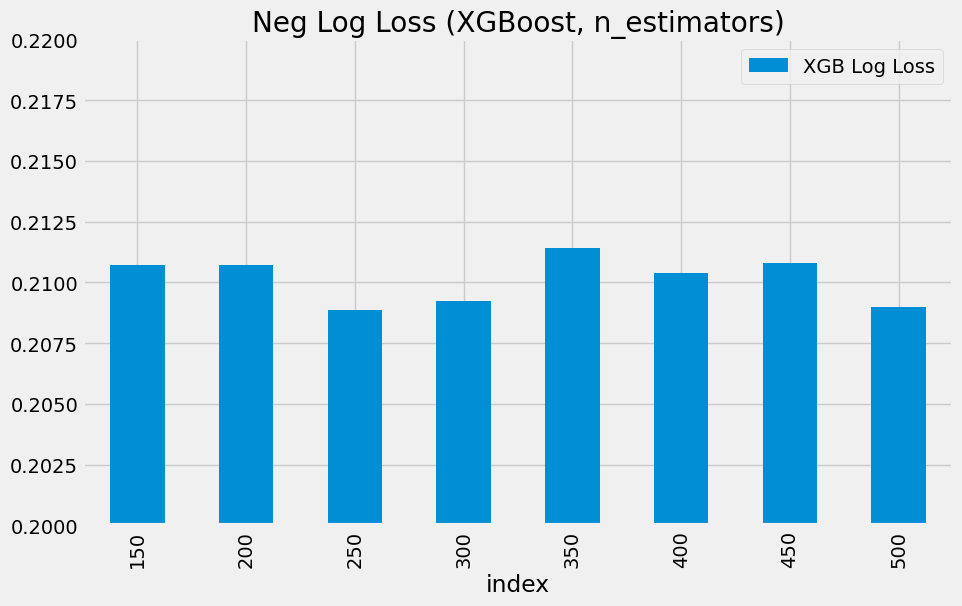

In [45]:
(
    DataFrame(
        data=rnd_grid_search.cv_results_["mean_test_score"].reshape(50, 1),
        index=[grid["xgb__n_estimators"] for grid in rnd_grid_search.cv_results_["params"]],
        columns=["XGB Log Loss"],
        )
    .reset_index(drop=False)
    .groupby("index")
    .mean().abs()
    .tail(8)
    .plot.bar(ylim=(0.20, 0.22), title="Neg Log Loss (XGBoost, n_estimators)")
    );

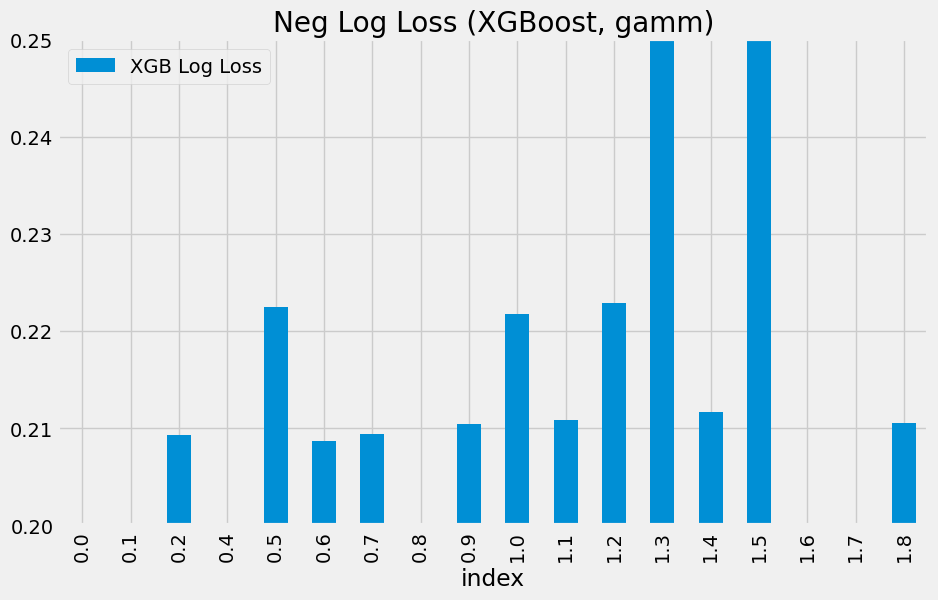

In [48]:
(
    DataFrame(
        data=rnd_grid_search.cv_results_["mean_test_score"].reshape(50, 1),
        index=[round(grid["xgb__gamma"], 1) for grid in rnd_grid_search.cv_results_["params"]],
        columns=["XGB Log Loss"],
        )
    .reset_index(drop=False)
    .groupby("index")
    .mean().abs()
    .plot.bar(ylim=(0.20, 0.25), title="Neg Log Loss (XGBoost, gamma)")
    );

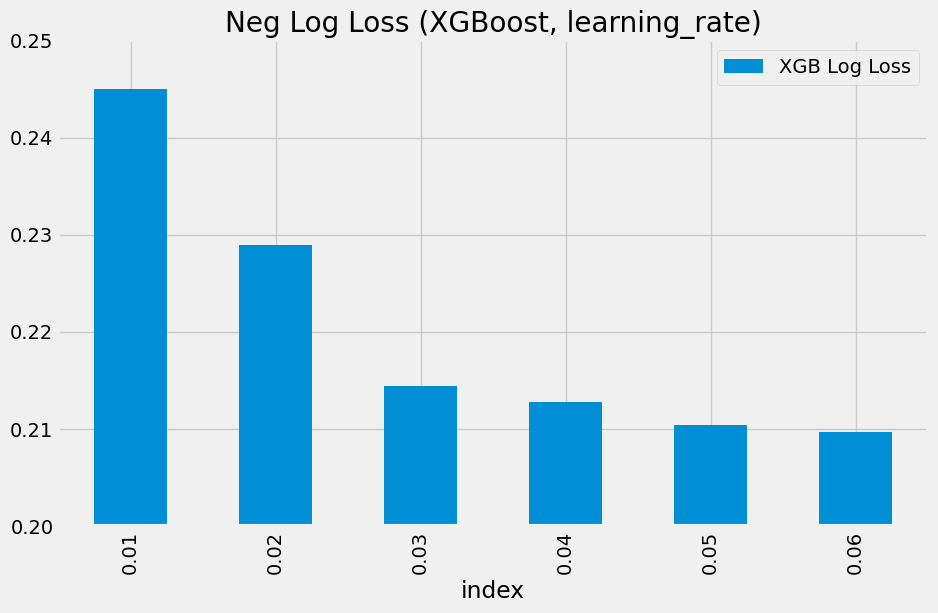

In [50]:
(
    DataFrame(
        data=rnd_grid_search.cv_results_["mean_test_score"].reshape(50, 1),
        index=[round(grid["xgb__learning_rate"], 2) for grid in rnd_grid_search.cv_results_["params"]],
        columns=["XGB Log Loss"],
        )
    .reset_index(drop=False)
    .groupby("index")
    .mean().abs()
    .plot.bar(ylim=(0.20, 0.25), title="Neg Log Loss (XGBoost, learning_rate)")
    );

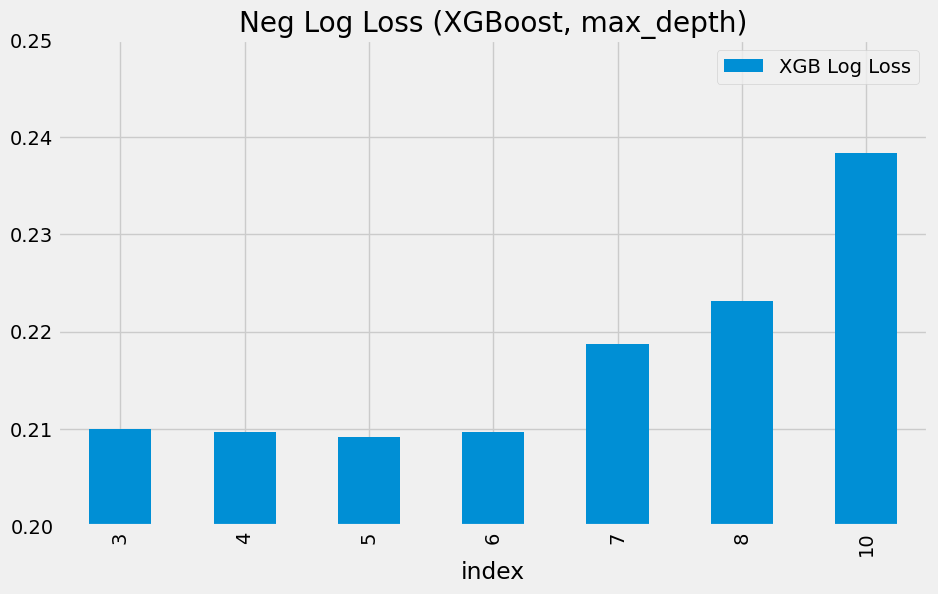

In [53]:
(
    DataFrame(
        data=rnd_grid_search.cv_results_["mean_test_score"].reshape(50, 1),
        index=[round(grid["xgb__max_depth"]) for grid in rnd_grid_search.cv_results_["params"]],
        columns=["XGB Log Loss"],
        )
    .reset_index(drop=False)
    .groupby("index")
    .mean().abs()
    .plot.bar(ylim=(0.20, 0.25), title="Neg Log Loss (XGBoost, max_depth)")
    );

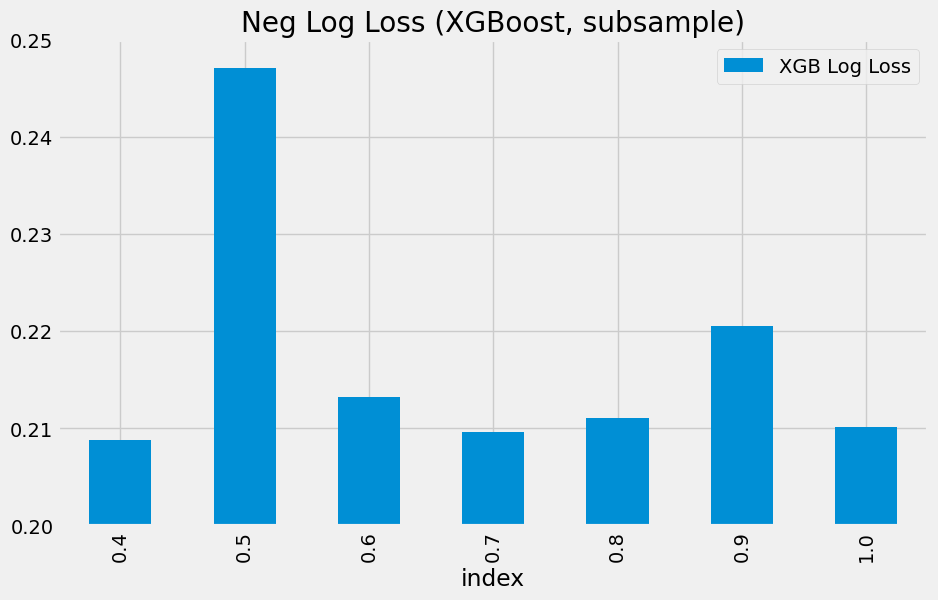

In [56]:
(
    DataFrame(
        data=rnd_grid_search.cv_results_["mean_test_score"].reshape(50, 1),
        index=[round(grid["xgb__subsample"], 1) for grid in rnd_grid_search.cv_results_["params"]],
        columns=["XGB Log Loss"],
        )
    .reset_index(drop=False)
    .groupby("index")
    .mean().abs()
    .head(7)
    .plot.bar(ylim=(0.20, 0.25), title="Neg Log Loss (XGBoost, subsample)")
    );

## 3. Validation

In [85]:
from numpy import float64 as np_float64
best_model_params = dict()
for param, value in rnd_grid_search.best_params_.items():
    if type(value) == np_float64:
        best_model_params[param.split("__")[1]] = round(value, 3)
    else:
        best_model_params[param.split("__")[1]] = value

In [86]:
base_model = BaseModel()
base_model.read_config("../models/config.yaml")
features, target = base_model.get_data()
base_model.build_base_pipeline()

best_xgb_model = XGBClassifier(**best_model_params)

base_model.base_pipeline.steps.append((
    "ipca", 
    IncrementalPCA(
        n_components=base_model.config["model"]["ipca"]["n_components"], 
        batch_size=ipca_batch,
        whiten=base_model.config["model"]["ipca"]["whiten"]
        ),
    ))

base_model.base_pipeline.steps.append(("xgb", best_xgb_model))

In [87]:
base_model.base_pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb019d74520>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MinMaxScaler())]),
                                                                                  <sklearn.com...
                               gamma=1.452, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.033, max_bin=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=350,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None, ...))])

In [88]:
best_model = base_model.base_pipeline.fit(X_train, y_train)

In [151]:
preds = best_model.predict_proba(X_test)[:,1]

In [152]:
len(preds)

1907778

In [155]:
from random import sample

rand_index = sample(range(0, len(preds)), int(len(preds)*0.5))
y_test_sample = np.array(y_test)[rand_index]
preds_sample = preds[rand_index]

In [144]:
import numpy as np
import seaborn as sns
from pandas.core.frame import DataFrame, Series
from pandas import concat
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

# Kudos to: Mateus Coelho
# https://www.kaggle.com/code/mateuscco/how-to-evaluate-model-calibration/notebook

def ece(y_test, preds, strategy = 'uniform'):
    df = DataFrame({'target': y_test, 'proba': preds, 'bin': np.nan})
    
    if(strategy == 'uniform'):
        lim_inf = np.linspace(0, 0.9, 10)
        for idx, lim in enumerate(lim_inf):
            df.loc[df['proba'] >= lim, 'bin'] = idx

    elif(strategy == 'quantile'):
        pass
    
    df_bin_groups = concat([df.groupby('bin').mean(), df['bin'].value_counts()], axis = 1)
    df_bin_groups['ece'] = (df_bin_groups['target'] - df_bin_groups['proba']).abs() * (df_bin_groups['bin'] / df.shape[0])
    return df_bin_groups['ece'].sum()

def make_report(y_test, preds):
    # Computing AUC
    auc = roc_auc_score(y_test, preds)
    display(f'AUROC: {auc}')
    display(f'AUROC: {2*auc-1}')
    display(f'Fraction of positive cases in the test set: {y_test.mean()}')
    display(f'Mean predicted value in the test set:       {preds.mean()}')
    display(f'ECE (equal width bins):       {ece(y_test, preds)}')
    
    # Plotting probabilities
    display('#### Histogram of the probability distribution')
    Series(preds).hist(bins = 40)
    plt.show()
    
    # Plotting KDE by class
    display('#### KDE plots of the probability distribution by class')
    fig, ax1 = plt.subplots()
    sns.kdeplot(preds[y_test == 0], label = 'No goal', ax = ax1)
    ax2 = ax1.twinx()
    sns.kdeplot(preds[y_test == 1], label = 'Goal within 10s', color = 'red', ax = ax2)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()
    
    # Plotting calibration
    display('#### Calibration curve (equal width bins)')
    fop, mpv = calibration_curve(y_test, preds, n_bins=10)
    plt.plot(mpv, fop, "s-", label='model')
    plt.plot([0,1],[0,1], label='ideal')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.show()
    
    display('#### Calibration curve (equal size bins)')
    fop, mpv = calibration_curve(y_test, preds, n_bins=10, strategy='quantile')
    plt.plot(mpv, fop, "s-", label='model')
    plt.plot([0,1],[0,1], label='ideal')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.show()

In [159]:
from sklearn.metrics import log_loss, classification_report, confusion_matrix

In [158]:
log_loss(y_test, preds)

0.2006539237018265

'AUROC: 0.7080552249574086'

'AUROC: 0.41611044991481716'

'Fraction of positive cases in the test set: 0.05736097176925198'

'Mean predicted value in the test set:       0.0597049742937088'

'ECE (equal width bins):       0.003274531134162758'

'#### Histogram of the probability distribution'

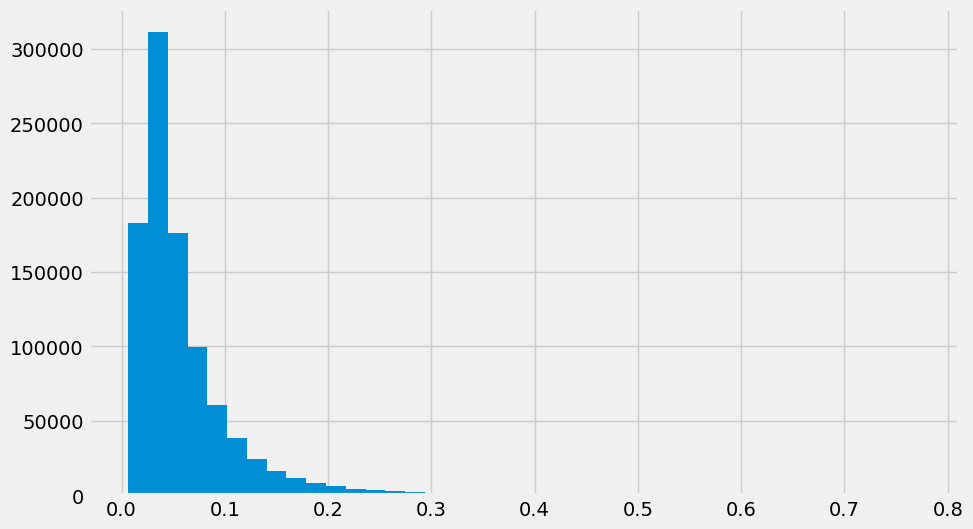

'#### KDE plots of the probability distribution by class'

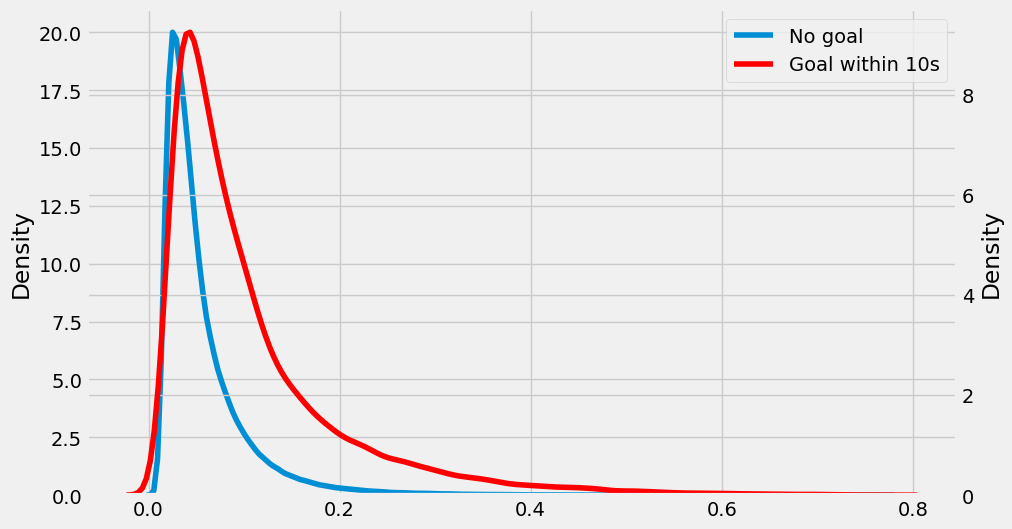

'#### Calibration curve (equal width bins)'

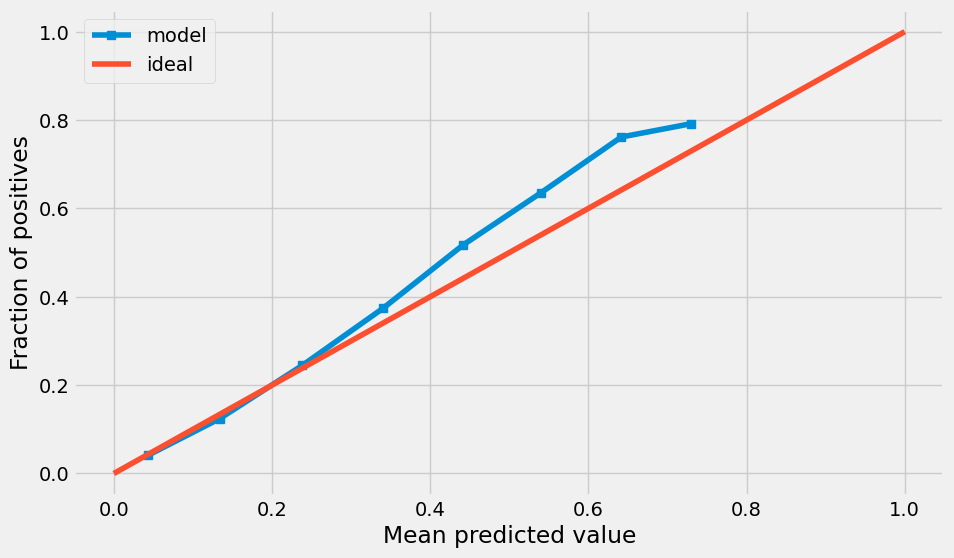

'#### Calibration curve (equal size bins)'

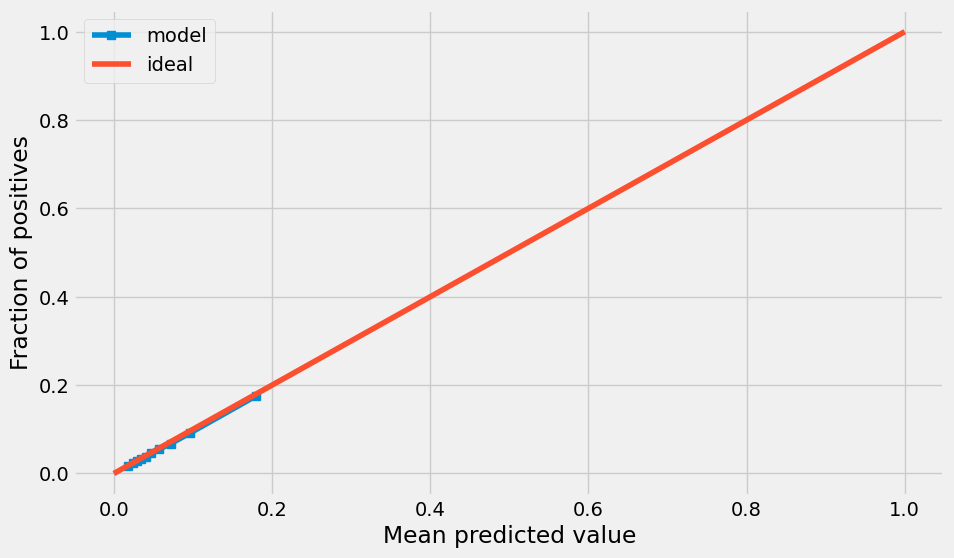

In [156]:
make_report(y_test_sample, preds_sample)

In [ ]:
# https://www.kaggle.com/code/alexryzhkov/how-to-kill-all-your-efforts/notebook
# https://www.kaggle.com/code/mateuscco/how-to-evaluate-model-calibration/notebook